In [1]:
# import library
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage.filters as filters

In [2]:
def crop_image_from_gray(img,tol=7):
  if img.ndim ==2:
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]
  elif img.ndim==3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img>tol        
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
        return img
    else:
      img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
      img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
      img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
      img = np.stack([img1,img2,img3],axis=-1)
      return img

def circle_crop_v2(img):
  img = crop_image_from_gray(img)

  height, width, depth = img.shape
  largest_side = np.max((height, width))
  img = cv2.resize(img, (largest_side, largest_side))

  height, width, depth = img.shape

  x = int(width / 2)
  y = int(height / 2)
  r = np.amin((x, y))

  circle_img = np.zeros((height, width), np.uint8)
  cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
  img = cv2.bitwise_and(img, img, mask=circle_img)
  img = crop_image_from_gray(img)

  return img

In [3]:
def exudate(img):
  # get green channel
  img = img[:,:,1]

  # Apply a median blur to remove salt-and-pepper noise
  img = cv2.medianBlur(img, 5)

  # Enhance the contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
  img = clahe.apply(img)

  # Apply Otsu's threshold
  _, thresholded = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Invert the image to segment the exudates
  thresholded = 255 - thresholded

  # # Apply morphological operations to remove small connected components and fill holes
  kernel = np.ones((5, 5), np.uint8)
  thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

  return thresholded

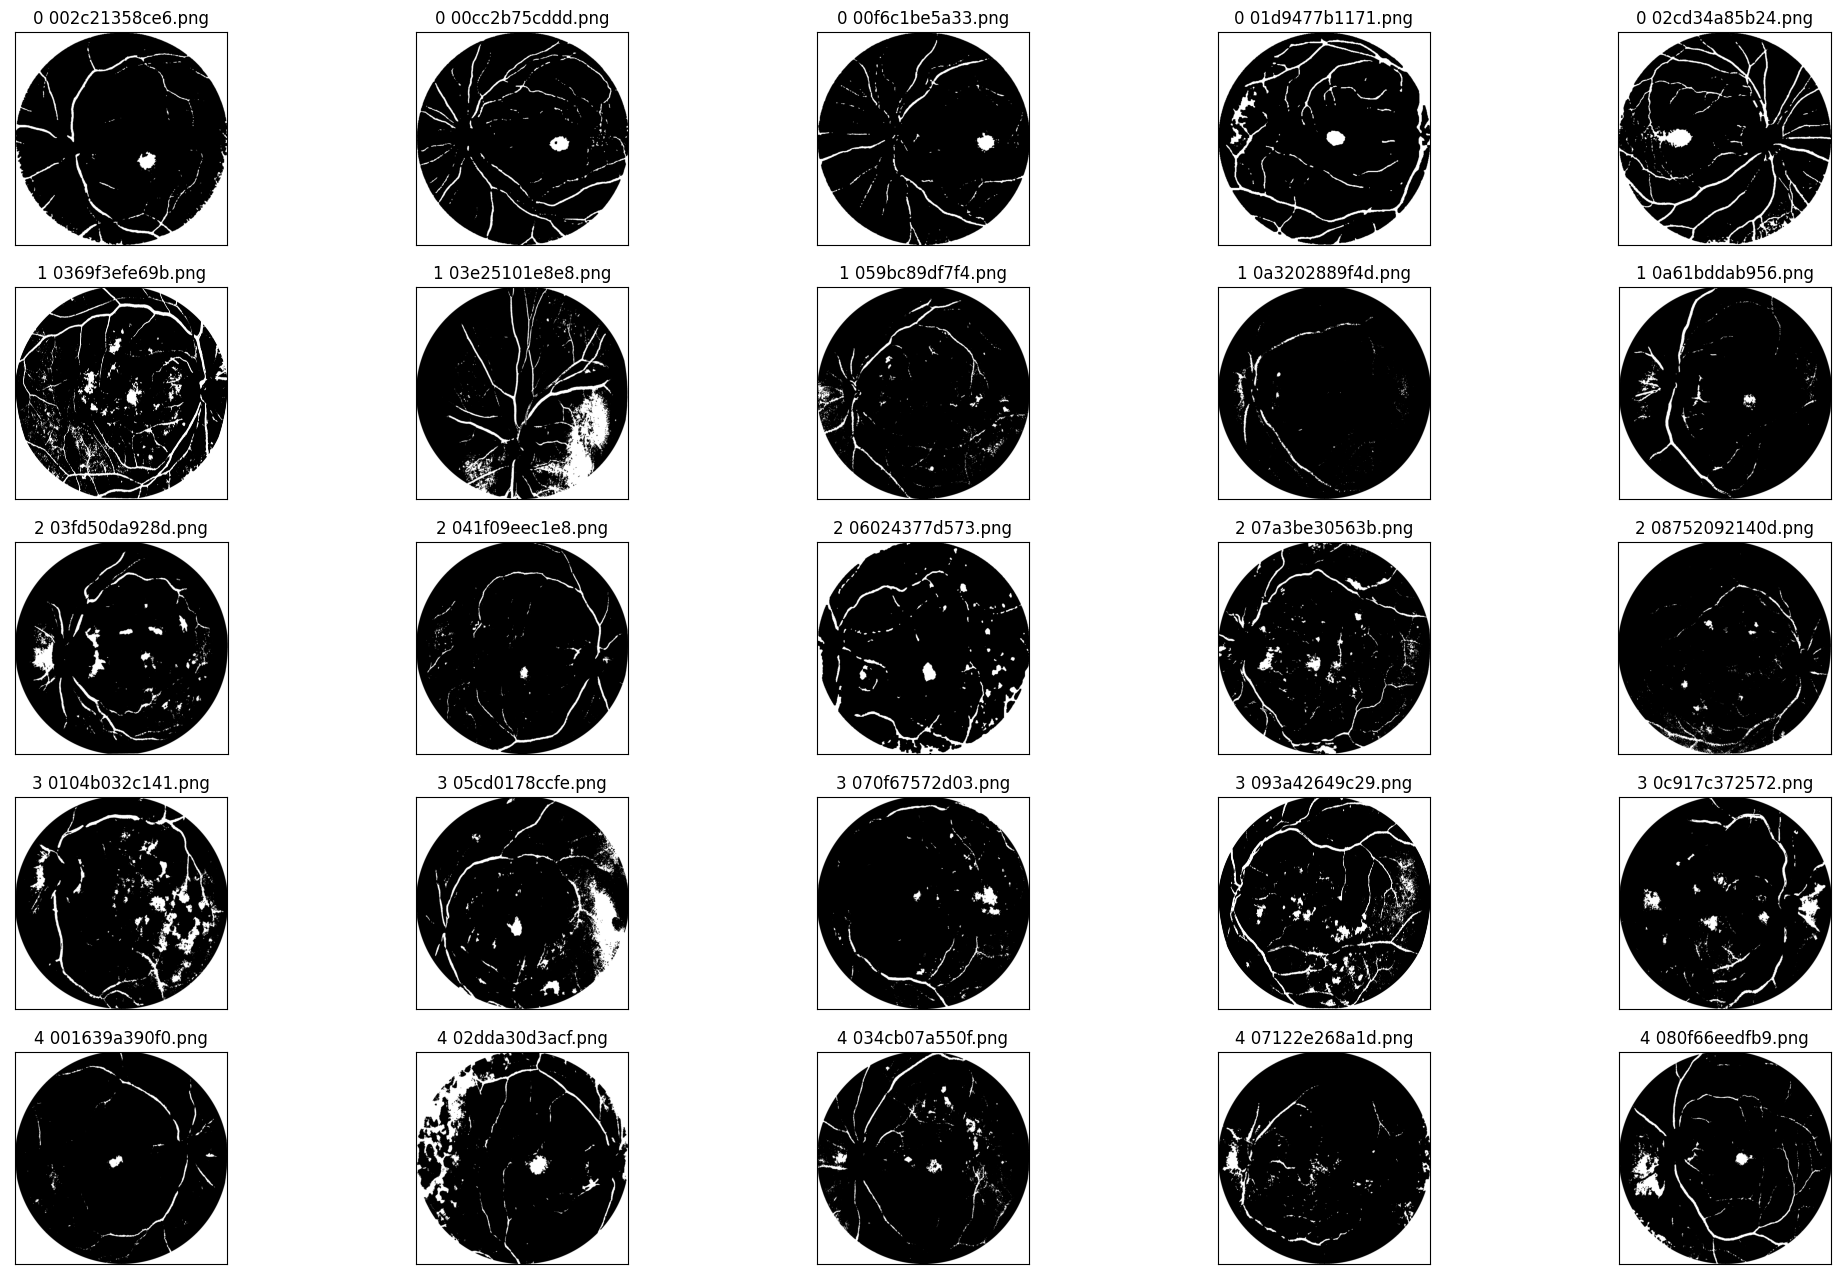

In [4]:
path_dataset = 'E:/Pawang Code/Diabetic Retinopathy/dataset_filter'
fig = plt.figure(figsize=(25, 16))
j= 0
for folder in os.listdir(path_dataset):
    sub_folder_files = os.listdir(os.path.join(path_dataset, folder))
    for i, filename in enumerate(sub_folder_files):
        ax = fig.add_subplot(5, 5, j+1, xticks=[], yticks=[])
        img = cv2.imread(os.path.join(path_dataset, folder, filename))
        img = circle_crop_v2(img)
        img = exudate(img)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(folder + ' ' + filename)
        j += 1
        if i == 4:
            break